# Full mathematical model of a single bubble
### About the model
aaa
### The differential equation
A system of first degree ordinary differencial equations can be written as: <br>
$\frac{d}{dt}\underline{x}=\underline{f}(\underline{x}, t)$ <br>
> $t\in\mathbb{R}$ <br>
> $\dot{\underline{x}},\ \underline{x}\in\mathbb{R}^{3+K}$ <br>
> $\underline{f}: \mathbb{R}^{4+K}\rightarrow\mathbb{R}^{3+K}$ <br>

Here <br>
$\underline{x}=\left(R,\dot{R},\ T,\ c_1,c_2,\ldots c_K\right)$
> R: bubble radius [m] <br>
> R_dot: d/dt(bubble radius) [m/s] <br>
> T: temperature [K] <br>
> c[1..K]: molar concentration of species [mol/cm^3] <br>

In [66]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
from scipy.integrate import solve_ivp   # differential equation solver
from scipy.signal import argrelmin   # loc min finding
import time   # runtime measurement
from numba import jit, njit   # Just In Time compiler
from numba.types import unicode_type, float64, float32, int64, int32   # JIT types
import importlib   # For reloading your own files

# my own files:
import chemkin_AR_HE as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made

# dot.notation access to dictionary attributes
# instead of dictionary['key'] you can use dictionary.key
class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Before the simulation

### Saturated vapour pressure
The saturated vapout pressure is an unique control parameter, as it is calculated from the ambient temperature via the Arden Buck equation:
$p_v\left(T\right)=611.21\exp{\left(\left(18.678-\frac{T}{234.5}\right)\frac{T}{257.14+T}\right)}$ <br>
> T: temperature [°C] <br>
> p_v: saturated vapout pressure [Pa]

### Initial conditions
The initial values can be written as: <br>
$\underline{x}\left(0\right)=\underline{x}_{0}=\left(R_0,\ \dot{R_0},\ T_0,c_{10},\ \ldots c_{K0}\right)$ <br>
Where <br>
$R_0=R_E$ <br>
> R_E: equilibrium radius [m]

$\dot{R_0}=0$ <br>
$T_0=T_{\infty}$ <br>
> T_inf: ambient temperature [K]

In [67]:
# You can store the control parameters in a dictionary:
cpar = dotdict(dict(
    ID=0,
    R_E=10e-6, # [m]
    ratio=20.0, # [-]
    P_inf=50e5, # [Pa]
    alfa_M=0.05, # [-]
    T_inf=303.15, # [m]
    surfactant=0.25, # [-]
))

In [68]:
@njit(float64(float64))
def VapourPressure(T): # [K]
    T -= 273.15 # [°C]
    return 611.21 * np.exp( (18.678 - T / 234.5) * (T / (257.14 + T)) ) # [Pa]

# usage:
cpar.P_v = VapourPressure(T=cpar.T_inf) # [Pa]
cpar.P_v

4245.12571625229

In [69]:
def InitialCondition(cpar):
    IC = np.zeros((par.K+3), dtype=np.float64)
    R_0 = cpar.ratio * cpar.R_E
    
    # Equilibrium state
    p_E = cpar.P_inf + 2 * cpar.surfactant * par.sigma / cpar.R_E # [Pa]
    V_E = 4.0 / 3.0 * cpar.R_E**3 * np.pi # [m^3]
    p_gas = p_E - cpar.P_v
    n_gas = p_gas * V_E / (par.R_g * cpar.T_inf) # [mol]
    
    # Isotermic expansion
    V_0 = 4.0 / 3.0 * R_0**3 * np.pi    # [m^3]
    n_H2O = cpar.P_v * V_0 / (par.R_g * cpar.T_inf) # [mol]
    c_H2O = n_H2O / V_0    # [mol/m^3]
    c_gas = n_gas / V_0    # [mol/m^3]

    # Initial conditions
    IC[0] = R_0   # R_0 [m]
    IC[1] = 0.0    # dRdt_0 [m/s]
    IC[2] = cpar.T_inf   # T_0 [K]
    IC[3 + par.indexOfWater] = c_H2O * 1.0e-6    # [mol/cm^3]
    IC[3 + par.indexOfArgon] = c_gas * 1.0e-6    # [mol/cm^3]

    return IC

# usage:
IC = InitialCondition(cpar)
IC

array([2.00000000e-04, 0.00000000e+00, 3.03150000e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68422045e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.47931797e-07, 0.00000000e+00, 0.00000000e+00])

In [70]:
#E_req = -int pdV + sigma(Amax-A0) + p_inf*(Vmax-V0)
"""CHANGE!!!!!!!!!!!!!"""

def Work(cpar):
    R_0 = cpar.ratio * cpar.R_E # [m]
    V_E = 4.0 / 3.0 * cpar.R_E**3 * np.pi    # [m^3]
    V_0 = 4.0 / 3.0 * R_0**3 * np.pi  # [m^3]
    
    p_E = cpar.P_inf + 2 * cpar.surfactant * par.sigma / cpar.R_E # [Pa]
    p_gas = p_E - cpar.P_v # [Pa]
    n_gas = p_gas * V_E / (par.R_g * cpar.T_inf) # [mol]
    
    W_0 = cpar.P_v * V_0 + n_gas * par.R_g * cpar.T_inf * np.log(V_0) + 4.0 * np.pi * par.sigma * cpar.surfactant * R_0**2
    W_E = cpar.P_v * V_E + n_gas * par.R_g * cpar.T_inf * np.log(V_E) + 4.0 * np.pi * par.sigma * cpar.surfactant * cpar.R_E**2
    return W_0 - W_E    # [J]

# usage
Work(cpar) # [J]

3.394622206120157e-07

## Pressures

In [71]:
@njit(float64[:](float64, float64, float64, float64, float64, float64, float64, float64))
def Pressure(R, R_dot, T, T_dot, M, sum_omega_dot, P_inf, surfactant):
    p_inf = P_inf
    p_inf_dot = 0.0
    p = 0.1 * M * par.R_erg * T
    p_dot = p * (sum_omega_dot / M + T_dot / T - 3.0 * R_dot/R)
    p_L = p - (2.0 * surfactant * par.sigma + 4.0 * par.mu_L * R_dot) / R
    p_L_dot = p_dot + (-2.0 * surfactant * par.sigma * R_dot + 4.0 * par.mu_L * R_dot ** 2) / (R ** 2)
    delta = (p_L - p_inf) / par.rho_L
    delta_dot = (p_L_dot - p_inf_dot) / par.rho_L
    return np.array([delta, delta_dot])

# usage:
Pressure(R=cpar.R_E, R_dot=0.0, T=cpar.T_inf, T_dot=0.0, M=np.sum(IC[3:]), sum_omega_dot=0.0, P_inf=cpar.P_inf, surfactant=cpar.surfactant)

array([-5007.74239142,     0.        ])

## NASA polynomials

In [72]:
# Corrects the temperature if it's not in the [T_low, T_high] intervall
@njit(float64(int32, float64))
def getT_act(k, T):
    if T < par.TempRange[k][0]: # T < T_low --> T_low
        return par.TempRange[k][0]
    elif T > par.TempRange[k][1]: # T > T_high --> T_high
        return par.TempRange[k][1]
    else:
        return T # T_low < T < T_high --> T

# Returns the right set of NASA coefficents
@njit(float64[:](int32, float64))
def getCoeffs(k, T_act):
    a = np.zeros((7), dtype=np.float64)
    if T_act <= par.TempRange[k][2]: # T_act <= T_mid
        a = par.a_low[k]
    else:  # T_mid < T_act
        a = par.a_high[k]
    return a

# returns molar heat capacities, enthalpies and entropies
@njit(float64[:, :](float64[:], float64))
def Thermodynamic(c, T):
    ret = np.zeros((4, par.K), dtype=np.float64)   # [C_p, H, S, C_v]
    exponent = np.array([1, 2, 3, 4, 5])
    for k in range(par.K):
    # get coefficients for T
        T_act = getT_act(k, T)
        a = getCoeffs(k, T_act)
            
     # calculate
        T_vec = T_act ** (exponent-1)    # [1, T, T^2, T^3, T^4]
        # Molar heat capacities at constant pressure (isobaric) [erg/mol/K]
        ret[0][k] = par.R_erg * np.sum(a[:par.N] * T_vec)
        # Enthalpies [erg/mol]
        ret[1][k] = par.R_erg * T_act * (np.sum(a[:par.N] * T_vec / exponent) + a[par.N] / T_act)
        # Entropies [erg/mol/K]
        ret[2][k] = par.R_erg * (a[0] * np.log(T_act) + np.sum(a[1:par.N] * T_vec[1:] / (exponent[1:]-1)) + a[par.N+1])
    # Molar heat capacities at constant volume (isochoric) [erg/mol/K]
    ret[3] = ret[0] - par.R_erg 
    return ret

# usage:
[C_p, H, S, C_v] = Thermodynamic(c=IC[3:], T=cpar.T_inf)
C_p

array([2.07861500e+08, 2.88749448e+08, 2.18816358e+08, 2.94052705e+08,
       2.98639722e+08, 3.36119824e+08, 2.91275480e+08, 3.49930572e+08,
       4.26069205e+08, 2.07861500e+08, 2.07861500e+08, 2.99214322e+08])

## Evaporation

In [73]:
@njit(float64[:](float64, float64, float64, float64, float64, float64))
def Evaporation(M, T, X_H2O, alfa_M, T_inf, P_v):
# condensation and evaporation
    p = 0.1 * M * par.R_erg * T
    p_H2O = X_H2O * p
    n_eva_dot = 1.0e3 * alfa_M * P_v / (par.W[par.indexOfWater] * np.sqrt(2.0 * np.pi * par.R_v * T_inf)) # W_H2O=par.W[5] is in g/mol --> *1000
    n_con_dot = 1.0e3 * alfa_M * p_H2O / (par.W[par.indexOfWater] * np.sqrt(2.0 * np.pi * par.R_v * T))
    n_net_dot = n_eva_dot - n_con_dot
# Molar heat capacity of water at constant volume (isochoric) [erg/mol/K]
    exponent = np.array([1, 2, 3, 4, 5])
    T_act = getT_act(5, T)
    a = getCoeffs(5, T)
    T_vec = T_act ** (exponent-1)    # [1, T, T^2, T^3, T^4]
    C_v = par.R_erg * (np.sum(a[:par.N] * T_vec) - 1.0)
    T_act = getT_act(5, T_inf); a = getCoeffs(5, T_inf)
    T_vec = T_act ** (exponent-1)    # [1, T, T^2, T^3, T^4]
    C_v_inf = par.R_erg * (np.sum(a[:par.N] * T_vec) - 1.0)
# Evaporation energy
    e_eva = C_v_inf * T_inf * 1e-7   # J/mol
    e_con = C_v * T * 1e-7
    evap_energy = n_eva_dot * e_eva - n_con_dot * e_con    # W/m^2
    return np.array([n_net_dot, evap_energy])

# usage:
X_H2O = IC[3+par.indexOfWater] / np.sum(IC[3:])
Evaporation(M=np.sum(IC[3:]), T=500.0, X_H2O=X_H2O, alfa_M=cpar.alfa_M, T_inf=cpar.T_inf, P_v=cpar.P_v)

array([-3.57522419e+00, -1.20791005e+05])

## Reactionrates

In [74]:
@njit(float64[:](float64, float64[:]))
def ForwardRate(T, M_eff):
# Reaction rate, equation 21
    k_forward = par.A * T ** par.b * np.exp(-par.E / (par.R_cal * T))
    
# Pressure dependent reactions, equations 35-43
    for j, i in enumerate(par.PressureDependentIndexes):    # i is the number of reaction, j is the index of i's place in par.PressureDependentIndexes
        k_inf = k_forward[i]    # par.A[i] * T ** par.b[i] * np.exp(-par.E[i] / (par.R_cal * T))
        k_0 = par.ReacConst[j][0] * T ** par.ReacConst[j][1] * np.exp(-par.ReacConst[j][2] / (par.R_cal * T))
        P_r = k_0 / k_inf * M_eff[i]
        logP_r = np.log10(P_r)
        
        # Keep in mind, some T** values are not used (if they are 0.0, not here)
        F_cent = (1.0 - par.Troe[j][0]) * np.exp(-T / par.Troe[j][1]) + par.Troe[j][0] * np.exp(-T / par.Troe[j][2]) + np.exp(-par.Troe[j][3] / T)
        logF_cent = np.log10(F_cent)
        c = -0.4 - 0.67 * logF_cent
        n = 0.75 - 1.27 * logF_cent
        d = 0.14
        logF = 1.0 / (1.0 + ((logP_r + c) / (n - d * (logP_r + c))) ** 2) * logF_cent
        F = 10.0 ** logF
        
        k_forward[i] = k_inf * P_r / (1.0 + P_r) * F
    return k_forward

# usage:
M_eff = np.sum(IC[3:]) * np.ones((par.I))    # M_eff: effective total concentration of the third-body species
for j, i in enumerate(par.ThirdBodyIndexes):
    M_eff[i] = np.sum(par.alfa[j] * IC[3:]) 
k_f = ForwardRate(T=cpar.T_inf, M_eff=M_eff)
k_f

array([4.44122182e+08, 1.61727778e+09, 4.34136164e+10, 1.57026291e+11,
       2.92160787e+15, 3.54082363e+14, 1.55500577e+16, 6.74083507e+17,
       3.59381656e+11, 1.44875851e+12, 5.00467744e+13, 3.25000000e+13,
       2.33475789e+13, 5.07449204e+11, 3.65802250e+09, 2.72193894e+11,
       8.73951754e+11, 6.19709720e+11, 3.18265037e+10, 1.33401928e+12,
       1.74848022e+11, 1.01868550e+11, 2.11804360e+14, 7.44313474e+13,
       5.30779533e+12, 1.98117882e+14, 2.62240183e+13, 5.33932260e+10,
       5.45116450e+13])

In [75]:
# FinalUson2022.pdf equation 28-32
@njit(float64[:](float64[:], float64[:], float64[:], float64, float64))
def BackwardRate(k_forward, S, H, T, P_inf):
    DeltaS = np.sum(par.nu * S, axis=1)
    DeltaH = np.sum(par.nu * H, axis=1)
    K_p = np.exp(DeltaS / par.R_erg - DeltaH / (par.R_erg * T))
    K_c = K_p * (P_inf * 10.0 / (par.R_erg * T)) ** np.sum(par.nu, axis=1)
    k_backward = k_forward / K_c
    return k_backward

# usage:
k_b = BackwardRate(k_forward=k_f, S=S, H=H, T=cpar.T_inf, P_inf=cpar.T_inf)
k_b

array([1.39298857e+19, 8.18795868e+09, 4.71091411e+00, 3.36558507e+00,
       3.81133343e-62, 7.45598881e-73, 1.02701798e-60, 9.54218740e-70,
       8.58405465e-27, 7.91251324e-28, 4.34040895e-15, 8.98654664e-26,
       1.38369230e-36, 1.05464111e-15, 7.60253612e-18, 1.55801813e-25,
       2.16136229e-39, 1.62852578e-01, 4.23434543e-02, 3.80406263e-11,
       4.98593112e-12, 4.15931402e+01, 3.42609460e-53, 1.20398295e-53,
       8.58575759e-55, 3.20470555e-53, 4.24193192e-54, 8.63675532e-57,
       8.81766799e-54])

In [76]:
@njit(float64[:](float64, float64[:], float64[:], float64[:], float64))
def ProductionRate(T, H, S, c, P_inf):
# equation 34
    M_eff = np.sum(c) * np.ones((par.I))    # effective total concentration of the third-body species
    for j, i in enumerate(par.ThirdBodyIndexes):
        M_eff[i] = np.sum(par.alfa[j] * c) 
    
    k_forward = ForwardRate(T=T, M_eff=M_eff)
    k_backward = BackwardRate(k_forward=k_forward, S=S, H=H, T=T, P_inf=P_inf)

# Net rate, equation 23
    q = np.zeros((par.I))
    for i in range(par.I):
        q[i] = k_forward[i] * np.prod(c ** par.nu_forward[i]) - k_backward[i] * np.prod(c ** par.nu_backward[i])
# Three body reactions, equation 33-34
    for j, i in enumerate(par.ThirdBodyIndexes):    # i is the number of reaction, j is the index of i in par.ThirdBodyIndexes
        if i not in par.PressureDependentIndexes:
            q[i] *= M_eff[i]
# Production rate, equation 24
    omega_dot = np.zeros((par.K))
    for k in range(par.K):
        omega_dot[k] = np.sum(par.nu[:, k] * q)
    
    return omega_dot

# usage:
ProductionRate(T=cpar.T_inf, H=H, S=S, c=IC[3:], P_inf=cpar.P_inf)

array([ 5.38219335e-76,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.38219335e-76, -5.38219335e-76,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Differencial equation

In [43]:
enable_heat_transfer = True
enable_evaporation = True
enable_evap_energy = True
enable_reactions = True

@njit(float64[:](float64, float64[:], float64, float64, float64, float64, float64))
def f(t, x, alfa_M, T_inf, P_v, P_inf, surfactant):    
    R = x[0]      # bubble radius [m]
    R_dot = x[1]   
    T = x[2]      # temperature [K]
    c = x[3:]     # molar concentration [mol/cm^3]
    M = np.sum(c) # sum of concentration
    X = c / M     # mole fraction [-]
    dxdt = np.zeros(x.shape, dtype = np.float64)
    
# d/dt R
    dxdt[0] = R_dot
# Evaporation
    n_net_dot = 0.0  
    evap_energy = 0.0
    if enable_evaporation:
        n_net_dot, evap_energy = Evaporation(M=M, T=T, X_H2O=X[par.indexOfWater], alfa_M=alfa_M, T_inf=T_inf, P_v=P_v)
# Thermodynamics
    # equation 11-14
    [C_p, H, S, C_v] = Thermodynamic(c=c, T=T)
    W_avg = np.sum(X * par.W)
    rho_avg = W_avg * M # or np.sum(c * par.W)
    C_p_avg = np.sum(X * C_p)
    C_v_avg = np.sum(X * C_v)
    # equation 15-18
    lambda_avg = np.sum(X * par.lambdas)
    chi_avg = 10.0 * lambda_avg * W_avg / (C_p_avg * rho_avg)
    l_th = np.inf
    if R_dot != 0.0:
        l_th = np.sqrt(R * chi_avg / abs(R_dot))
    l_th = min(l_th, R / np.pi)
    Q_th_dot = 0.0
    if enable_heat_transfer:
        Q_th_dot = lambda_avg * (T_inf - T) / l_th
# d/dt c, equations 44-45
    omega_dot = np.zeros((par.K))
    if enable_reactions:
        omega_dot = ProductionRate(T=T, H=H, S=S, c=c, P_inf=P_inf)
    c_dot = omega_dot - c * 3.0 * R_dot / R
    c_dot[par.indexOfWater] += 1.0e-6 * n_net_dot * 3.0 / R    # water evaporation
    M_dot = np.sum(c_dot)
    dxdt[3:] = c_dot
# d/dt T
    # equation 25-26
    Q_r_dot = -np.sum(H * omega_dot)
    
    p = 0.1 * M * par.R_erg * T
    n_t = M * 4.0/3.0 * np.pi * R ** 3    # molar concentration
    T_dot = (Q_r_dot + 30.0 / R * (-p * R_dot + Q_th_dot + evap_energy)) / (M * C_v_avg)
    dxdt[2] = T_dot
# d/dt R_dot
    [delta, delta_dot] = Pressure(
        R=R, R_dot=R_dot, T=T, T_dot=T_dot,
        M=M, sum_omega_dot=np.sum(omega_dot),
        P_inf=P_inf, surfactant=surfactant
    )   # delta = (p_L-p_inf) / rho_L
    Nom = (1.0 + R_dot / par.c_L) * delta + R / par.c_L * delta_dot - (1.5 - 0.5 * R_dot / par.c_L) * R_dot ** 2
    Den = (1.0 - R_dot / par.c_L) * R + 4.0 * par.mu_L / (par.c_L * par.rho_L)
    
    dxdt[1] = Nom / Den
    
    return dxdt

# usage:
f(t=0.0, x=IC, alfa_M=cpar.alfa_M, T_inf=cpar.T_inf, P_v=cpar.P_v, P_inf=cpar.P_inf, surfactant=cpar.surfactant)

array([ 0.00000000e+00, -2.50212502e+07,  9.55294445e-09,  5.38219335e-76,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.38219335e-76,
        5.32907052e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Solving

In [88]:
# This funfction solves the differential equation, and returns the numerical solution
# Error codes:
    # 0: succecfully solved with LSODA solver
    # 1: LSODA solver didn't converge, but Radau solver worked
    # 2: LSODA solver had a fatal error, but Radau solver worked
    # 3: Radau solver didn't converge (NO SOLUTION!)
    # 4: Radau solver had a fatal error (NO SOLUTION!)
def solve(cpar, t_int=np.array([0.0, 1.0])):
    error_code = 0
    start = time.process_time()
    IC = InitialCondition(cpar)
    #f(t, x, alfa_M, T_inf, P_v, P_inf, surfactant)
    
    try:
        num_sol = solve_ivp(f, t_int, IC, method='LSODA', atol = 1e-10, rtol=1e-10, args=(cpar.alfa_M, cpar.T_inf, cpar.P_v, cpar.P_inf, cpar.surfactant))
        # docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
        if num_sol.success == False: error_code = 1
    except:
        error_code = 2
    if error_code != 0:
        try:
            num_sol = solve_ivp(f, t_int, IC, method='Radau', atol = 1e-10, rtol=1e-10, args=(cpar.alfa_M, cpar.T_inf, cpar.P_v, cpar.P_inf, cpar.surfactant))
            if num_sol.success == False: error = 3
        except:
            error_code = 4
    
    end = time.process_time()
    elapsed_time = (end - start)
    
    return num_sol, error_code, elapsed_time

# usage:
num_sol, error_code, elapsed_time = solve(cpar)
num_sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 67128
     njev: 2487
      nlu: 2487
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 3.99660285e-13, 7.99320571e-13, ...,
       4.37876320e-01, 6.84371718e-01, 1.00000000e+00])
 t_events: None
        y: array([[ 2.00000000e-004,  2.00000000e-004,  2.00000000e-004, ...,
         1.01620349e-005,  1.01620349e-005,  1.01620349e-005],
       [ 0.00000000e+000, -9.99999986e-006, -1.99999996e-005, ...,
        -2.11381795e-015,  2.06581025e-015, -2.87853311e-015],
       [ 3.03150000e+002,  3.03150000e+002,  3.03150000e+002, ...,
         3.03150000e+002,  3.03150000e+002,  3.03150000e+002],
       ...,
       [ 2.47931797e-007,  2.47931797e-007,  2.47931797e-007, ...,
         1.89008063e-003,  1.89008063e-003,  1.89008063e-003],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [

In [96]:
# This function gets the numerical solution and the control parameters, and returns some datas about the simulation
def getData(cpar, num_sol, error_code, elapsed_time):
# copy cpar:
    data = dotdict(dict(
        ID=cpar.ID,
        R_E=cpar.R_E,
        ratio=cpar.ratio,
        P_inf=cpar.P_inf,
        alfa_M=cpar.alfa_M,
        T_inf=cpar.T_inf,
        surfactant=cpar.surfactant
    ))
# runtime and error, return if solving wasn't succesful
    data.error_code = error_code
    data.elapsed_time = elapsed_time # [s]
    
    if error_code==3 or error_code==4:
        return data
    
# collapse time (first loc min of R)
    loc_min = argrelmin(num_sol.y[:][0])
    data.collapse_time = 0.0
    if not len(loc_min[0]) == 0:
        data.collapse_time = num_sol.t[loc_min[0][0]]
# Energy calculations
    data.T_max = np.max(num_sol.y[:][2]) # maximum of temperature peaks [K]
    data.x_final = num_sol.y[:, -1] # final values of [R, R_dot, T, c_1, ... c_K]
    last_V = 4.0 / 3.0 * (100.0 * data.x_final[0]) ** 3 * np.pi # [cm^3]
    data.n_H2 = data.x_final[3+par.indexOfHydrogen] * last_V # [mol]
    data.n_O2 = data.x_final[3+par.indexOfOxygen] * last_V # [mol]
    m_H2 = 1e-3 * data.n_H2 * par.W[par.indexOfHydrogen] # [kg]
    data.work = Work(cpar) # [J]
    data.energy = 1e-6 * data.work / m_H2 # [MJ/kg]
    
    return data
    
# usage:
data = getData(cpar, num_sol, error_code, elapsed_time)
data

{'ID': 0,
 'R_E': 1e-05,
 'ratio': 20.0,
 'P_inf': 5000000.0,
 'alfa_M': 0.05,
 'T_inf': 303.15,
 'surfactant': 0.25,
 'error_code': 0,
 'elapsed_time': 2.4375,
 'collapse_time': 2.6689567521360034e-06,
 'T_max': 4189.915734957215,
 'x_final': array([ 1.01620349e-05, -2.87853311e-15,  3.03150000e+02, -2.90584427e-25,
         6.21055890e-05, -3.53392197e-26,  3.08602082e-05, -3.22764906e-26,
         1.68422045e-06, -6.39907162e-28, -1.04708979e-11,  3.85188425e-07,
         1.89008063e-03,  0.00000000e+00,  6.77704339e-55]),
 'n_H2': 2.7299917607345993e-13,
 'n_O2': 1.3565303109730984e-13,
 'work': 3.394622206120157e-07,
 'energy': 621.7275551789056}

NameError: name 'R_E' is not defined

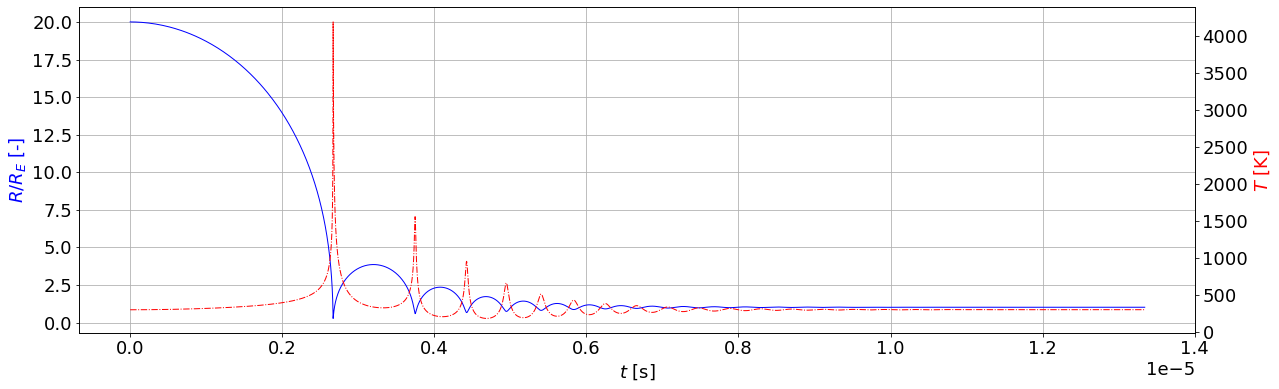

In [99]:
# This funfction solves the differential equation, and plots it
def plot(cpar, t_int=np.array([0.0, 1.0]), base_name=''):
    num_sol, error_code, elapsed_time = solve(cpar, t_int)
    data = getData(cpar, num_sol, error_code, elapsed_time)
    
# Calculations
    time_to_plot = 5.0 * data.collapse_time
    if t_int[1] != 1.0: time_to_plot = t_int[1]
    end_index = np.where(num_sol.t > time_to_plot)[0][0]

    t = num_sol.t[:end_index] # [s]
    R = num_sol.y[0, :end_index] # [m]
    R_dot = num_sol.y[1, :end_index] # [m/s]
    T = num_sol.y[2, :end_index] # [K]
    c = num_sol.y[3:, :end_index] # [mol/cm^3]

    V = 4.0 / 3.0 * (100.0 * R) ** 3 * np.pi # [cm^3]
    n = c * V

# plot R and T
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(axisbelow=True)
    ax2 = ax1.twinx()
    ax1.plot(t, R / cpar.R_E, label = "R [m]", color = 'b', linewidth = 1.0)
    ax2.plot(t, T, label = "T [K]", color = 'r', linewidth = 1.0, linestyle = '-.')

    ax1.set_ylabel('$y1$ [-]')
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$R/R_E$ [-]', color = 'b')
    ax2.set_ylabel('$T$ [K]', color = 'r')
    ax1.grid()
    
# textbox with initial conditions
    text = f"""
    Initial conditions:
      {'$R_E$':<25} {1e6*cpar.R_E: .2f}  $[\mu m]$
      {'$R_0/R_E$':<25} {cpar.ratio: .2f}  $[-]$
      {'$P_∞$':<25} {1e-5*cpar.P_inf: .2f}  $[bar]$
      {'$α_M$':<25} {cpar.alfa_M: .2f}  $[-]$
      {'$T_∞$':<25} {T_inf-273.15: .2f}  $[°C]$
      {'$P_{vapour}$':<25} {P_v: .1f}  $[Pa]$
      {'$surfactant$':<25} {surfactant: .2f}  $[-]$
    """
    ax1.text(
        0.75, 0.95, # coordinates
        text, transform=ax1.transAxes, horizontalalignment='left',
        verticalalignment='top', fontsize=16, fontstyle='oblique',
        bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 10},
    )
    
    plt.show()
    #if saveit:
    #    fig.savefig('images/plot_R.png')

# plot reactions
    fig = plt.figure(figsize=(20, 9))
    ax = fig.add_subplot(axisbelow=True)

    plt.ylim([1e-23, 1e-11])
    ax.set_yscale('log')
    #O,    H,    H2,     OH,   O2,      H2O,   HO2, H2O2,   O3,  OH_ex
    for i, element in enumerate(par.species):
        ax.plot(t, n[i], label = '$' + element + '$', linewidth = 1.0)

    ax.set_xlabel('$t$ [s]')
    ax.set_ylabel('$n_k$ [mol]')
    ax.grid()
    ax.legend()

    plt.show()
    #if saveit:
    #    fig.savefig('images/plot_mol.png')
    
# usage:
plot(cpar)